&emsp;&emsp;如下图有一个10×7的长方形格子世界，标记有一个起始位置 S 和一个终止目标位置 G，格子下方的数字表示对应的列中风的强度。当个体进入该列的某个格子时，会按图中箭头所示的方向自动移动数字表示的格数，借此来模拟真实世界中的风。   
&emsp;&emsp;同样，格子世界是有边界的，个体任意时刻只能处在世界内部的一个格子中。个体并不清楚这个世界的构造以及是否有风。但是个体会记住曾经经过的格子，下次在进入这个格子时，它能记住这个格子曾经什么时候来过。格子可以执行的行为是朝上、下、左、右移动一步，每移动一步只要不是进入目标位置都给予一个 -1 的惩罚，直至进入目标位置后获得奖励 0 同时永久停留在该位置。现在的问题是个体应该遵循怎样的策略才能尽快的从起始位置到达目标位置。  
![image](./image/1.bmp)

In [2]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [3]:
# 定义世界的 height
WORLD_HEIGHT = 7
# 定义世界的 width
WORLD_WIDTH = 10

# 每一列的风强度
WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

# 动作集A
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

# 定义探索率EPSILON
EPSILON = 0.1

# 定义步长
ALPHA = 0.5

# 定义奖励R
REWARD = -1.0

# 定时起始位置和终止位置
START = [3, 0]
GOAL = [3, 7]

In [78]:
def step(state, action):
    i, j = state
    if action == ACTION_UP:
        return [max(i - 1 - WIND[j], 0), j]
    elif action == ACTION_DOWN:
        return [max(min(i + 1 - WIND[j], WORLD_HEIGHT - 1), 0), j]
    elif action == ACTION_LEFT:
        return [max(i - WIND[j], 0), max(j - 1, 0)]
    elif action == ACTION_RIGHT:
        return [max(i - WIND[j], 0), min(j + 1, WORLD_WIDTH - 1)]
    else:
        assert False

def episode(q_value):
    # 保存在该episode下的步数
    time = 0

    # 初始化起始位置
    state = START
    
    """
    np.random.binomial(n, p, size=None)
    表示对一个二项分布进行采样，参数中的n,p分别对应于公式中的n,p，函数的返回值表示n中成功（success）的次数。
    size表示采样的次数
    for i in range(0,50):
        print (np.random.binomial(1, EPSILON))
    """
    
    # 使用epsilon-greedy算法选择动作A
    if np.random.binomial(1, EPSILON) == 1:
        action = np.random.choice(ACTIONS)#选择该action的概率为EPSILON*（1/4）
    else:
        #获得初始状态state对应的Q,即动作价值（四个动作，所以有四个动作价值）
        values_ = q_value[state[0], state[1], :]
        # 以1-EPSILON的概率贪婪选择最大的动作价值，分母是可选行为的个数
        action = np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])
    
    # 循环，直至到达终点
    while state != GOAL:
        # 生成下一个state
        next_state = step(state, action)
        #选择动作
        if np.random.binomial(1, EPSILON) == 1:
            next_action = np.random.choice(ACTIONS)
        else:
            values_ = q_value[next_state[0], next_state[1], :]
            next_action = np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

        # 更新价值函数Q（S，A）
        q_value[state[0], state[1], action] += \
            ALPHA * (REWARD + q_value[next_state[0], next_state[1], next_action] -
                     q_value[state[0], state[1], action])
        state = next_state
        action = next_action
        time += 1
    return time

Optimal policy is:
['R', 'U', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R']
['R', 'R', 'R', 'U', 'R', 'R', 'R', 'U', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'U', 'R', 'D']
['D', 'R', 'R', 'R', 'R', 'R', 'U', 'G', 'R', 'D']
['R', 'D', 'R', 'R', 'R', 'U', 'U', 'D', 'L', 'L']
['R', 'R', 'R', 'R', 'R', 'U', 'U', 'D', 'L', 'L']
['R', 'D', 'R', 'R', 'U', 'U', 'U', 'U', 'L', 'U']
Wind strength for each column:
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


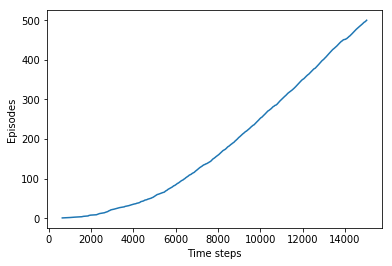

In [83]:
%matplotlib inline
# 随机初始化所有的Q,大小为WORLD_HEIGHT*WORLD_WIDTH*4，4代表4个动作
q_value = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
# 定义迭代轮数T
episode_limit = 500

# 保存每一步迭代结果
steps = []

# 进行迭代
ep = 0
while ep < episode_limit:
    steps.append(episode(q_value))
    ep += 1
# 保存步数
steps = np.add.accumulate(steps)
#展示随着迭代轮次的增加，步数的变化
plt.plot(steps, np.arange(1, len(steps) + 1))
plt.xlabel('Time steps')
plt.ylabel('Episodes')
# 输出最优策略
optimal_policy = []
for i in range(0, WORLD_HEIGHT):
    optimal_policy.append([])
    for j in range(0, WORLD_WIDTH):
        if [i, j] == GOAL:
            optimal_policy[-1].append('G')
            continue
        bestAction = np.argmax(q_value[i, j, :])
        if bestAction == ACTION_UP:
            optimal_policy[-1].append('U')
        elif bestAction == ACTION_DOWN:
            optimal_policy[-1].append('D')
        elif bestAction == ACTION_LEFT:
            optimal_policy[-1].append('L')
        elif bestAction == ACTION_RIGHT:
            optimal_policy[-1].append('R')
print('Optimal policy is:')
for row in optimal_policy:
    print(row)
print('Wind strength for each column:\n{}'.format([str(w) for w in WIND]))